# TV's golden age is real

* [tidytuesday data description](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-01-08)
* [Dave Robinson's analysis](https://github.com/dgrtwo/data-screencasts/blob/master/golden-age-tv.Rmd)

In [1]:
import pandas as pd

from siuba import *
from siuba.dply.vector import row_number, n

from plotnine import *

In [2]:

tv_ratings = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-01-08/IMDb_Economist_tv_ratings.csv")

tv_ratings["date"] = pd.to_datetime(tv_ratings.date)

In [3]:
tv_ratings >> filter(_, _.title.str.contains("Buffy"))

,titleId,seasonNumber,title,date,av_rating,share,genres
275,tt0118276,1,Buffy the Vampire Slayer,1997-04-14,7.9629,11.70,"Action,Drama,Fantasy"
276,tt0118276,2,Buffy the Vampire Slayer,1997-12-31,8.4191,19.41,"Action,Drama,Fantasy"
277,tt0118276,3,Buffy the Vampire Slayer,1999-01-29,8.6233,17.12,"Action,Drama,Fantasy"
278,tt0118276,4,Buffy the Vampire Slayer,2000-01-19,8.2205,16.19,"Action,Drama,Fantasy"
279,tt0118276,5,Buffy the Vampire Slayer,2001-01-12,8.3028,11.99,"Action,Drama,Fantasy"
280,tt0118276,6,Buffy the Vampire Slayer,2002-01-29,8.1008,8.45,"Action,Drama,Fantasy"
281,tt0118276,7,Buffy the Vampire Slayer,2003-01-18,8.0460,9.89,"Action,Drama,Fantasy"


## Do most shows get better or worse over time?

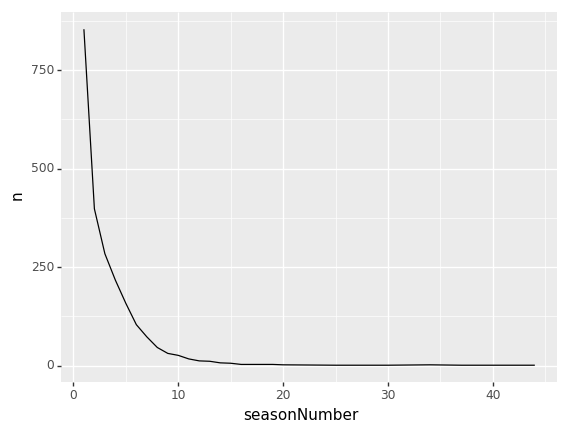

<ggplot: (-9223372036570461475)>

In [4]:
(tv_ratings
  >> count(_, _.seasonNumber)
  >> ggplot(aes("seasonNumber", "n"))
   + geom_line()
  )

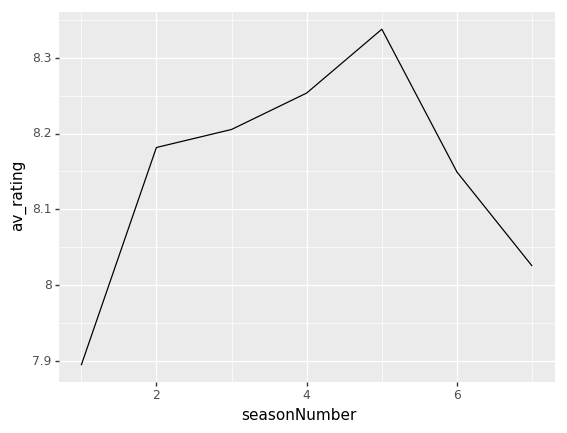

<ggplot: (-9223372036571224453)>

In [5]:
(tv_ratings
  >> filter(_, _.seasonNumber <= 7)
  >> group_by(_, _.seasonNumber)
  >> summarize(_, av_rating = _.av_rating.mean())
  >> ggplot(aes("seasonNumber", "av_rating"))
   + geom_line()
  )

In [6]:
# Note: if filter used transform under the hood (for single var exprs)
#       it would go a bit faster. In general, grouping + subsetting
#       appears fairly slow in pandas compared to dplyr
tv_ratings_full_show = (tv_ratings
  >> group_by(_, "title")
  >> filter(_,
       (_.seasonNumber == 1).any(),
       (_.seasonNumber == row_number(_) + 1).all()
     )
  )

# (tv_ratings_full_show
#   >> filter(_, n(_) >= 5, _.seasonNumber <= 5)
#   >> ungroup(_)
#   >> ggplot(aes("seasonNumber", "av_rating", group = "seasonNumber")) + geom_boxplot()
#   )

## What are the highest rated seasons of TV?

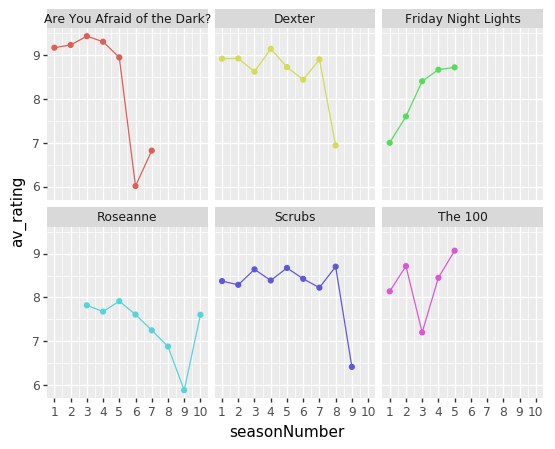

<ggplot: (305509366)>

In [7]:
by_show = (tv_ratings
  >> group_by(_, "title")
  >> summarize(_,
       avg_rating = _.av_rating.mean(),
       sd = _.av_rating.std(),
       seasons = n(_)
     )
  >> arrange(_, -_.avg_rating)
  )

most_variable_shows = by_show \
  >> filter(_, _.seasons >= 5) \
  >> arrange(_, -_.sd) \
  >> head(_, 6)

(tv_ratings
  >> inner_join(_, most_variable_shows, "title")
  >> ggplot(aes("seasonNumber", "av_rating", color = "title"))
   + geom_line()
   + geom_point()
   + scale_x_continuous(breaks = range(11))
   + facet_wrap("~ title")
   + theme(legend_position = "none")
  )

## Has TV been getting better or worse over time?

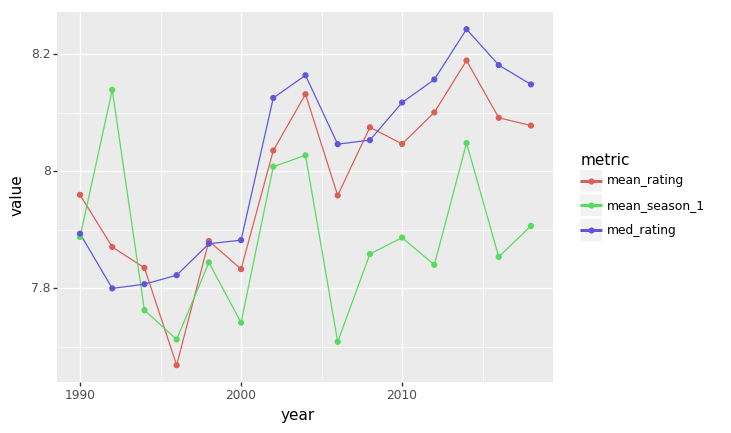

<ggplot: (306322566)>

In [8]:
(tv_ratings
  >> mutate(_, year = _.date.dt.year)
  >> ggplot(aes("av_rating"))
   + geom_histogram()
   + facet_wrap("~year")
  )

by_year = (tv_ratings
  >> group_by(_, year = 2 * (_.date.dt.year // 2))
  >> summarize(_,
       mean_rating = _.av_rating.mean(),
       med_rating = _.av_rating.median(),
       mean_season_1 = _.av_rating[_.seasonNumber == 1].mean(),
       avg_season = _.seasonNumber.mean(),
       observations = n(_)
       )
  )

(by_year
  >> gather(_, "metric", "value", -_.year, -_.observations, -_.avg_season, -_.sd)
  >> ggplot(aes("year", "value", color = "metric"))
   + geom_line()
   + geom_point()
  )

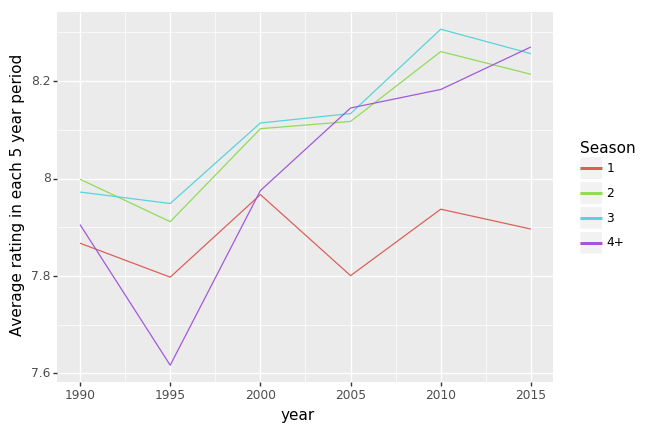

<ggplot: (308892662)>

In [9]:
(tv_ratings
  >> group_by(_,
       year = 5 * (_.date.dt.year // 5),
       seasonNumber = if_else(_.seasonNumber >= 4, "4+", _.seasonNumber)
       )
  >> summarize(_, mean_rating = _.av_rating.mean(), observations = _.shape[0])
  >> ggplot(aes("year", "mean_rating", color = "seasonNumber"))
   + geom_line()
   + labs(color = "Season", y = "Average rating in each 5 year period")
  )

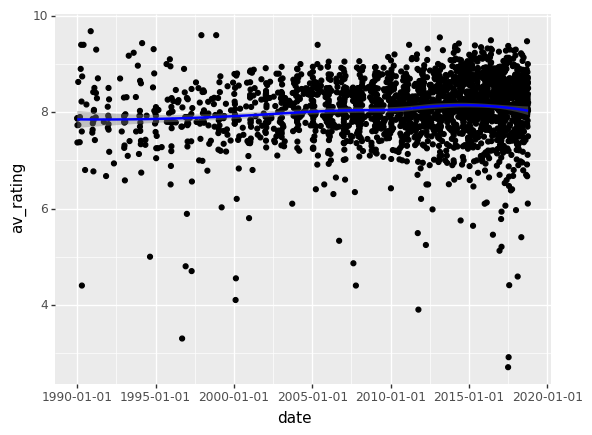

<ggplot: (305513897)>

In [10]:
(tv_ratings
  >> ggplot(aes("date", "av_rating"))
   + geom_point()
   + geom_smooth(method = "loess", fill = "grey", color = "blue")
  )

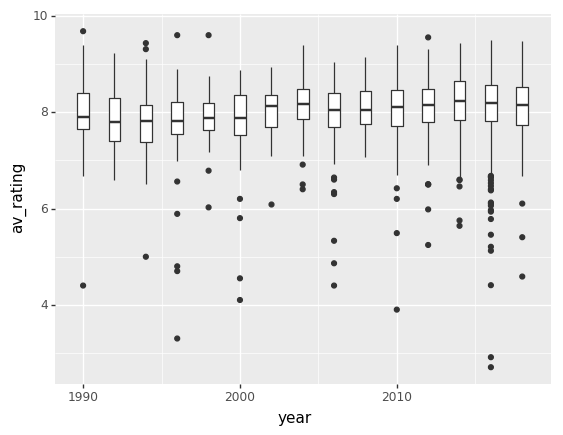

<ggplot: (308842672)>

In [11]:
(tv_ratings
  >> mutate(_, year = 2 * (_.date.dt.year // 2))
  >> ggplot(aes("year", "av_rating", group = "year"))
   + geom_boxplot()
  )

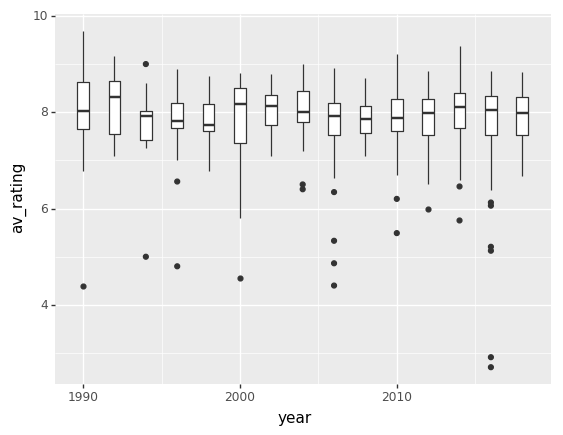

<ggplot: (-9223372036546224366)>

In [12]:
(tv_ratings
  >> filter(_, _.seasonNumber == 1)
  >> mutate(_, year = 2* (_.date.dt.year // 2))
  >> ggplot(aes("year", "av_rating", group = "year"))
   + geom_boxplot()
  )

## Show survival

If season 1 is good, what's the probability they get a season 2?

In [13]:
first_3_seasons = (tv_ratings
  >> filter(_, _.seasonNumber <= 3)
  >> group_by(_, "title")
  >> mutate(_, date_first_season = _.date.min())
  >> ungroup(_)
  >> transmute(_,
       _.titleId, _.title, _.date_first_season, _.av_rating,
       seasonNumber = "season" + _.seasonNumber.astype("str")
       )
  >> distinct(_, "title", "seasonNumber", _keep_all = True)
  >> spread(_, "seasonNumber", "av_rating")
  >> filter(_, ~_.season1.isna())
  >> filter(_, _.date_first_season <= "2017-01-01")
  )



In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

fit = smf.glm("np.invert(season2.isna()) ~ season1",
              data = first_3_seasons, family = sm.families.Binomial()).fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Generalized Linear Model Regression Results                                            
===================================================================================================================================
Dep. Variable:     ['np.invert(season2.isna())[False]', 'np.invert(season2.isna())[True]']   No. Observations:                  685
Model:                                                                                 GLM   Df Residuals:                      683
Model Family:                                                                     Binomial   Df Model:                            1
Link Function:                                                                       logit   Scale:                          1.0000
Method:                                                                               IRLS   Log-Likelihood:                -446.01
Date:                                                                     Fri, 03 May 2019   Deviance:                       892.02
Time:                                                                             18:28:00   Pearson chi2:                     690.
No. Iterations:                                                                          4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5372      1.160      6.495      0.000       5.263       9.812
season1       -0.9683      0.146     -6.643      0.000      -1.254      -0.683
==============================================================================
"""

/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


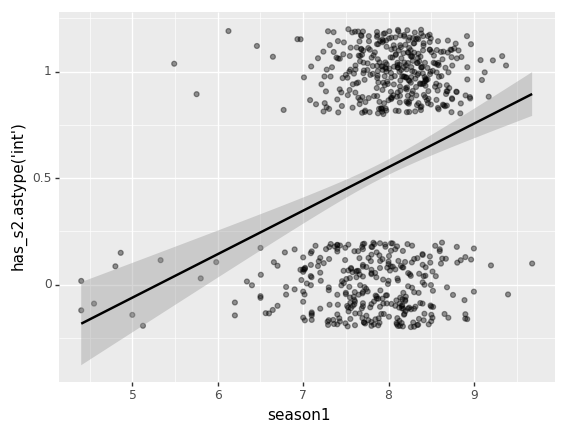

<ggplot: (308569008)>

In [15]:
# Ah! Can't fit logistic w/ plotnine yet :/
# see: https://github.com/has2k1/plotnine/issues/265
first_3_seasons \
  >> mutate(_, has_s2 = ~_.season2.isna()) \
  >> ggplot(aes("season1", "has_s2.astype('int')")) \
  + geom_point(position = position_jitter(width = 0, height = .2), alpha = .4) \
  + geom_smooth(method = 'glm', method_args = {'family': sm.families.Binomial()})

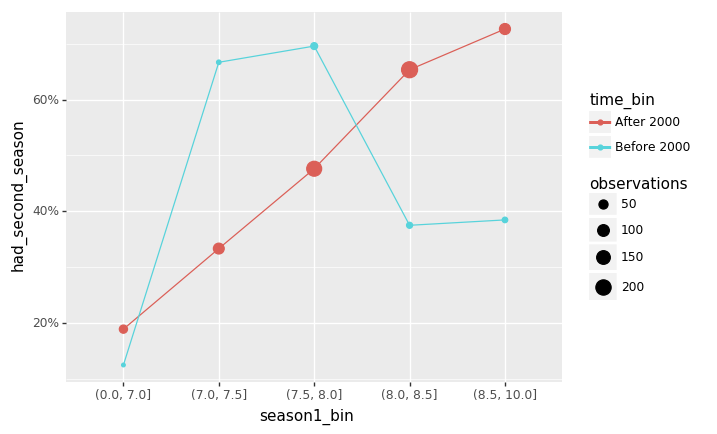

<ggplot: (308585613)>

In [16]:
from siuba.meta_hook import pandas as pd_
from mizani.formatters import percent_format

(first_3_seasons
  >> group_by(_, season1_bin = pd_.cut(_.season1, [0, 7, 7.5, 8, 8.5, 10]),
                 time_bin = if_else(_.date_first_season < "2000-01-01", "Before 2000", "After 2000"))
  >> summarize(_, had_second_season = (~_.season2.isna()).mean(),
               observations = n(_))
  >> ggplot(aes("season1_bin", "had_second_season", color = "time_bin", group = "time_bin"))
   + geom_line()
   + geom_point(aes(size = "observations"))
   + scale_y_continuous(labels = percent_format())
  )

In [17]:
# TODO: full analysis with splines

# Misc

In [18]:
def lists_to_df(l, colname):
    return [pd.DataFrame({colname: x}) for x in l]

genre_ratings = (tv_ratings
  >> mutate(_, data = lambda d: lists_to_df(d.genres.str.split(","), "genre"))
  >> unnest(_, "data")
  )


## How common are different genres?

In [19]:
genre_summary = (genre_ratings
  >> group_by(_, "genre", year = _.date.dt.year)
  >> summarize(_, avg_rating = _.av_rating.mean(), n = _.shape[0])
  )

In [20]:
common_genres = (genre_summary
  >> group_by(_, "year")
  >> filter(_, _.n.rank(ascending = False) < 5)
  >> ungroup(_)
  >> count(_, "genre", sort = True)
  >> pipe(_.loc[:,"genre"])
  )
common_genres

4        Drama
3        Crime
6      Mystery
2       Comedy
0       Action
1    Adventure
5       Family
7      Romance
Name: genre, dtype: object

## What are the animated genres?

In [21]:
genre_ratings >> filter(_, _.genre == "Animation") >> distinct(_, "title")

,title
573,BoJack Horseman
1303,Daria
1368,Death Note
1693,Erased
1721,F Is for Family
2249,Hey Arnold!
2547,King of the Hill
3336,Mushi-Shi
3426,Neon Genesis Evangelion
3578,Over the Garden Wall


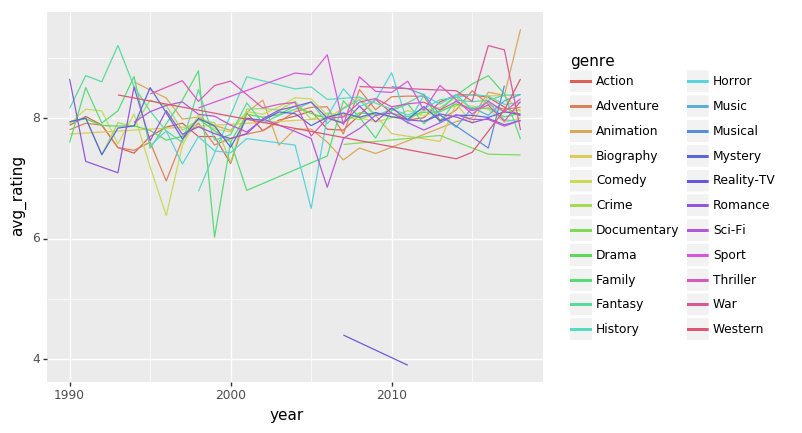

<ggplot: (314218837)>

In [22]:
genre_summary \
  >> ggplot(aes("year", "avg_rating", color = "genre")) + geom_line()

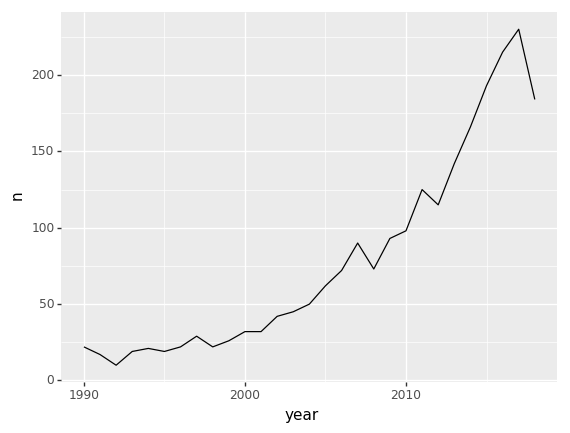

<ggplot: (-9223372036540496675)>

In [23]:
(tv_ratings
  >> count(_, year = _.date.dt.year)
  >> ggplot(aes("year", "n")) + geom_line()
  )